In [1]:
import _pickle as cPickle
import gzip, numpy, copy, math
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, Draw, rdmolops
from rdkit.Chem.AtomPairs import Pairs
from rdkit.Chem import rdMolDescriptors
from matplotlib import cm
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB

In [2]:
# helper functions
def getNormalizedWeights(weights):
    '''Normalizes a set of weight vectors'''
    for i in range(len(weights)):
        tmp = [math.fabs(j) for j in weights[i]]
        current_max = max(tmp)
        weights[i] = [j/current_max for j in weights[i]]
    return weights

def generateSimilarityMaps(mols, weights, fp):
    '''Generates a similarity map for a set of molecules and weights'''
    # colormap to use
    mycm = cm.PiYG
    # loop over molecules
    for i,m in enumerate(mols):
        fig = Draw.MolToMPL(m, coordScale=1.5, size=(250,250))
        # the values 0.02 and 0.01 can be adjusted for the size of the molecule
        x,y,z = Draw.calcAtomGaussians(m, 0.02, step=0.01, weights=weights[i])
        # use the maximum absolute peak as maximum scale
        maxscale = max(math.fabs(numpy.min(z)), math.fabs(numpy.max(z)))
        # this does the coloring
        fig.axes[0].imshow(z, cmap=mycm, interpolation='bilinear', origin='lower', extent=(0,1,0,1), vmin=-maxscale, vmax=maxscale)
        # this draws 10 contour lines
        # alternatively also the z values for the lines can be specified
        fig.axes[0].contour(x, y, z, 10, colors='k', alpha=0.5)
        # this writes the figure in a file
        fig.savefig('pics/mol'+str(i+1)+'_'+fp+'.png', bbox_inches='tight')

In [3]:
# hard coded variables
bit_size = 1024
radius = 2

In [4]:
# load reference compound and two test molecules
mols = []
for line in open('data/cmps.dat', 'r'):
    mols.append(Chem.MolFromSmiles(line))

In [5]:
# load training actives and inactives for ML methods
training = []
for line in open('data/training_cmps.dat', 'r'):
    line = line.rstrip().split()
    # line contains SMILES and active/inactive information
    training.append(line)

In [6]:
# precalculate fingerprints for reference compound
ref_morgan2 = AllChem.GetMorganFingerprintAsBitVect(mols[0], radius, bit_size)
ref_cmorgan2 = AllChem.GetMorganFingerprint(mols[0], radius)
ref_fmorgan2 = AllChem.GetMorganFingerprintAsBitVect(mols[0], radius, bit_size, useFeatures=True)
ref_ap = Pairs.GetAtomPairFingerprint(mols[0])

In [7]:
# precalculate fingerprints and bit information for test molecules
fps_morgan2 = []
fps_cmorgan2 = []
fps_fmorgan2 = []
fps_ap = []
info_morgan2 = []
info_cmorgan2 = []
info_fmorgan2 = []
num_mols = len(mols) - 1
mols = [mols[i+1] for i in range(num_mols)] # remove reference cmp from list
for m in mols:
    info = {}
    fps_morgan2.append(AllChem.GetMorganFingerprintAsBitVect(m, radius, bit_size, bitInfo=info))
    info_morgan2.append(info)
    info = {}
    fps_cmorgan2.append(AllChem.GetMorganFingerprint(m, radius, bitInfo=info))
    info_cmorgan2.append(info)
    info = {}
    fps_fmorgan2.append(AllChem.GetMorganFingerprintAsBitVect(m, radius, bit_size, useFeatures=True, bitInfo=info))
    info_fmorgan2.append(info)
    fps_ap.append(Pairs.GetAtomPairFingerprint(m))

generate atom pairs similarity maps


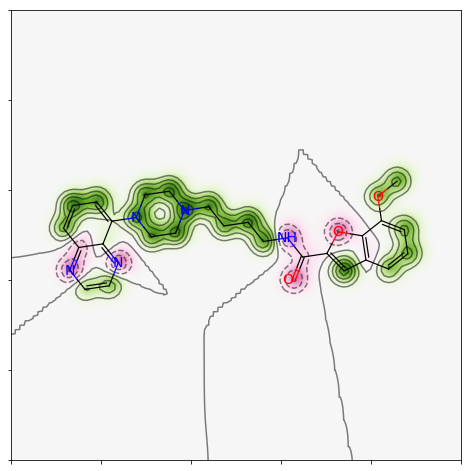

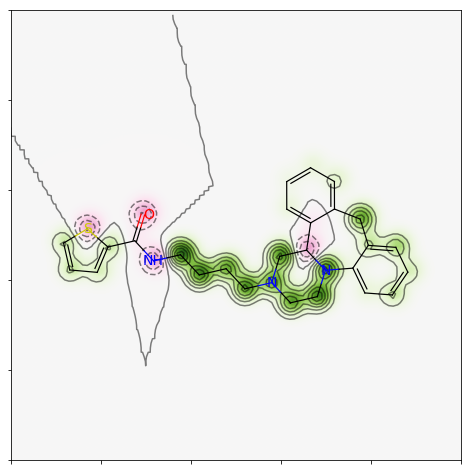

In [9]:
### ATOM PAIRS
print("generate atom pairs similarity maps")
# calculate weights
mol_weights = []
for i,m in enumerate(mols):
    weights = []
    orig_simil = DataStructs.DiceSimilarity(ref_ap, fps_ap[i])
    matrix = rdmolops.GetDistanceMatrix(m)
    for at1 in range(m.GetNumAtoms()):
        new_fp = copy.deepcopy(fps_ap[i])
        for at2 in range(m.GetNumAtoms()):
            bit = Pairs.pyScorePair(m.GetAtomWithIdx(at1), m.GetAtomWithIdx(at2), matrix[at1][at2])
            new_fp[bit] -= 1
        new_simil = DataStructs.DiceSimilarity(ref_ap, new_fp)
        weights.append(orig_simil - new_simil)
    mol_weights.append(weights)
# normalization
mol_weights = getNormalizedWeights(mol_weights)
# draw similarity maps
generateSimilarityMaps(mols, mol_weights, 'ap')